# Interpolation to $\sigma_p$ levels test using LFRic-Atmosphere output.

In [1]:
from functools import partial

In [2]:
import iris
import matplotlib.pyplot as plt
import numpy as np
from iris.experimental import stratify

import aeolus
from aeolus.calc import spatial_mean, time_mean
from aeolus.const import init_const
from aeolus.core import AtmoSim
from aeolus.io import load_data
from aeolus.model import lfric
from pouch.clim_diag import calc_derived_cubes, last_n_day_mean

In [3]:
import paths
import pouch
import quickplot as qplt
from shared import TF_CASES, MODELS

In [4]:
plt.style.use("custom.mplstyle")
pouch.RUNTIME.figsave_stamp = False

In [5]:
# height_theta, height_rho = the_run.extract("height_above_reference_ellipsoid")
height_theta = np.linspace(0, 32000, 33)
height_rho = np.linspace(1000, 32000, 32) - 500

In [6]:
sim_label = "hs"
sim_prop = TF_CASES[sim_label]

model_key = "lfric"
model_prop = MODELS[model_key]

In [7]:
dset = load_data(
    sorted((model_prop["results_path"] / sim_label).glob(f"{sim_label}*_regr.nc"))
)
pres = dset.extract_cube(lfric.pres)
const = init_const(sim_prop["planet"])
calc_derived_cubes(dset, const=const, model=lfric)
p_sfc = pres.extract(iris.Constraint(**{lfric.z: 0}))
sigma_p = pres / p_sfc
sigma_p.rename(lfric.s)

## Zonal mean cross-sections

Create a callable to pass to the interpolation routine. Use linear extrapolation.

In [8]:
INTERPOLATOR = partial(
    stratify.stratify.interpolate,
    interpolation=stratify.stratify.INTERPOLATE_LINEAR,
    extrapolation=stratify.stratify.EXTRAPOLATE_LINEAR,
)

Create an array of $\sigma_p=p/p_s$ levels, close to the table A1 in Mayne et al. (2014).

In [9]:
SIGMA_LEVELS = np.linspace(1, 0.01, 34)

Test the interpolation using the cube of height

In [10]:
gpot_height = dset.extract_cube("geopotential_height")

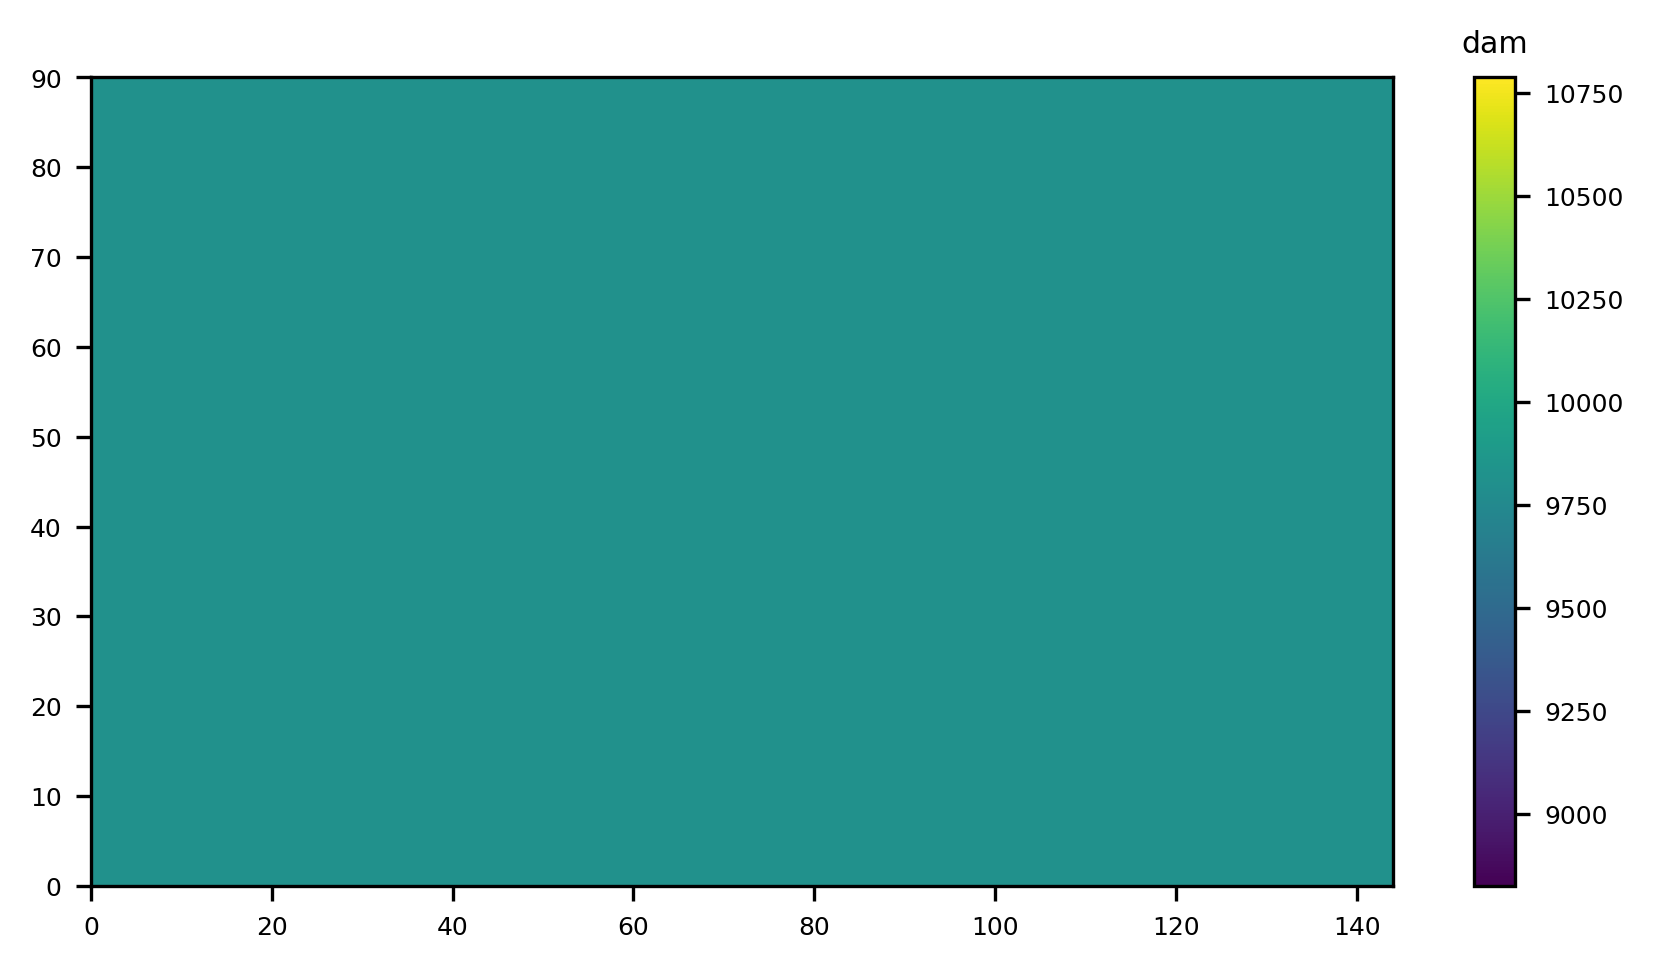

In [11]:
plt.pcolormesh(gpot_height[-1, 1, ...].data)
cbar = plt.colorbar()
cbar.ax.set_title("dam");

In [12]:
gpot_height_slev = stratify.relevel(
    gpot_height[-1, ...],
    sigma_p[-1, ...],
    SIGMA_LEVELS,
    axis=lfric.z,
    interpolator=INTERPOLATOR,
)

Text(0.5, 1.0, '(test) p=0.97')

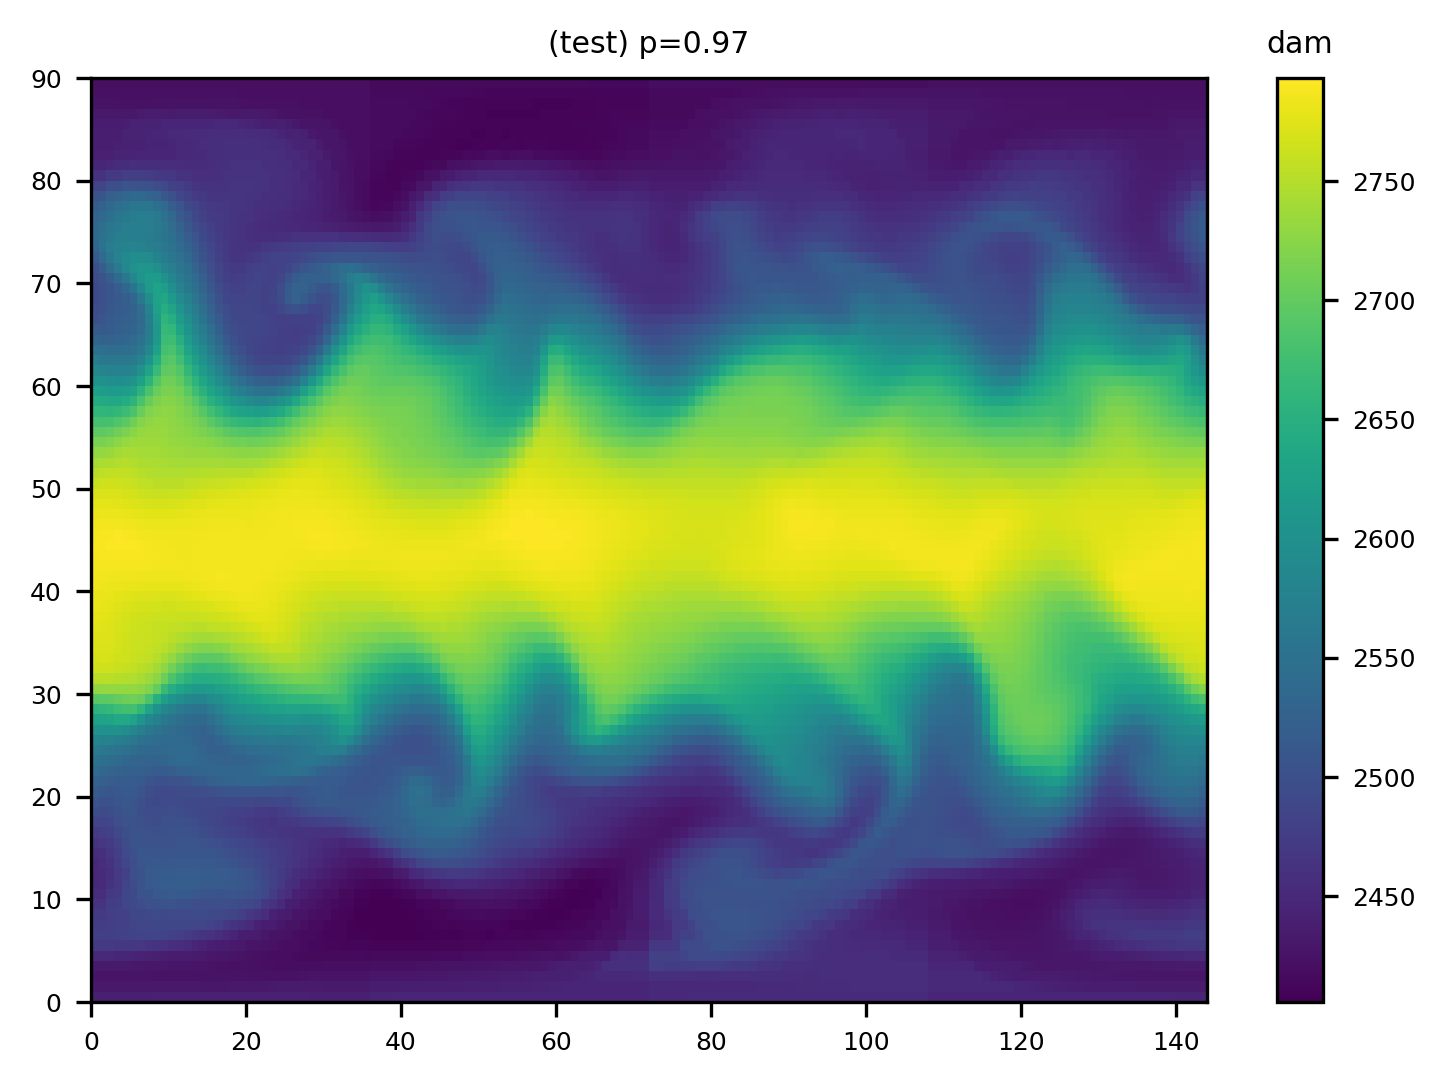

In [13]:
fig, ax = plt.subplots(figsize=(6, 4))
p0 = ax.pcolormesh(gpot_height_slev[1, ...].data)
cbar = fig.colorbar(p0)
cbar.ax.set_title("dam")
ax.set_title(
    f"(test) p={gpot_height_slev[1, ...].coord('atmosphere_hybrid_sigma_pressure_coordinate').points[0]}"
)

In [14]:
gpot_height_slev_gm = spatial_mean(gpot_height_slev, model=lfric)
normalised_height = gpot_height_slev_gm.data / gpot_height_slev_gm.data.max()

Compare with Table A1 in Mayne et al. (2014).

In [15]:
[*zip(np.round(SIGMA_LEVELS, decimals=2), np.round(normalised_height, decimals=6))]

[(1.0, 0.0),
 (0.97, 0.009188),
 (0.94, 0.018376),
 (0.91, 0.027564),
 (0.88, 0.03699),
 (0.85, 0.047081),
 (0.82, 0.057174),
 (0.79, 0.06734),
 (0.76, 0.078274),
 (0.73, 0.08944),
 (0.7, 0.100695),
 (0.67, 0.112666),
 (0.64, 0.124989),
 (0.61, 0.137593),
 (0.58, 0.15091),
 (0.55, 0.164542),
 (0.52, 0.178926),
 (0.49, 0.193898),
 (0.46, 0.209591),
 (0.43, 0.226038),
 (0.4, 0.24345),
 (0.37, 0.261741),
 (0.34, 0.281419),
 (0.31, 0.302266),
 (0.28, 0.324877),
 (0.25, 0.349606),
 (0.22, 0.37675),
 (0.19, 0.407185),
 (0.16, 0.442283),
 (0.13, 0.484203),
 (0.1, 0.536658),
 (0.07, 0.607964),
 (0.04, 0.719941),
 (0.01, 1.0)]